In [13]:
# импортируем необходимые функции из библиотеки
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

# для построения моделей воспользуемся sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [14]:
def metrics(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)
    roc_auc=roc_auc_score(y_true, y_pred)
    print(f'accuracy: {acc}\nf1: {f1}\nroc auc: {roc_auc} ')

In [15]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return   

In [16]:
data=pd.read_csv('train_mutual_info.csv')

In [17]:
data.shape

(22232, 16)

In [18]:
data.head(340)

,"Потенциальный дебит жидкости, м3/сут",Забойное давление,"Потенциальный дебит нефти, т/сут",Пласт1/Добыча жидкости м3/сут,Целевое забойное давление,"Свободный газ на входе при подаче Q опт, %",ЗамерыМРМ/Дебит жидкости (ТМ),ЗамерыМРМ/Дебит нефти (ТМ),ЗамерыМРМ/Обводненность (ТМ),ЗамерыМРМ/Дебит газа (ТМ),ЗамерыМРМ/Давление буферное (ТМ),ЗамерыМРМ/Давление затрубное (ТМ),ЗамерыМРМ/Давление линейное (ТМ),ЗамерыМРМ/Газовый фактор (ТМ),ЗамерыМРМ/Давление на приеме насоса (ТМ),Failure
0,200.887102,96.990352,24.226985,130.118667,36.33,3.497414,137.0,20.52,85.021898,0.0,10.0,10.0,7.3,0.0,25.5,0
1,222.101207,116.316656,26.785406,137.359839,37.43,3.497414,136.0,20.34,85.044118,0.0,10.0,10.0,7.3,0.0,25.0,0
2,222.101207,116.316656,26.785406,137.359839,37.43,3.497414,137.0,20.59,84.970803,0.0,10.0,10.0,7.5,0.0,24.8,0
3,222.101207,116.316656,26.785406,137.359839,37.43,3.497414,137.0,20.54,85.007299,0.0,10.0,10.0,7.4,0.0,24.8,0
4,222.101207,116.316656,26.785406,137.359839,37.43,3.497414,136.0,20.46,84.955882,0.0,10.0,10.0,7.3,0.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,243.002025,163.368404,19.537363,111.798435,117.48,3.097364,113.0,11.32,89.982301,0.0,10.0,10.0,6.8,0.0,31.4,0
336,257.603742,168.153858,22.782475,145.684696,116.61,2.959485,113.0,11.34,89.964602,0.0,10.0,10.0,6.8,0.0,31.4,0
337,257.603742,168.153858,22.782475,145.684696,116.61,2.959485,113.0,11.34,89.964602,0.0,10.0,10.0,6.8,0.0,31.4,1
338,257.603742,168.153858,22.782475,145.684696,116.61,2.959485,113.0,11.34,89.964602,0.0,10.0,10.0,6.8,0.0,31.4,0


In [19]:
data=data.fillna(0)

In [20]:
X=data.drop(['Failure'], axis=1)
y=data['Failure']

In [21]:
X_long = pd.DataFrame({0: X.values.flatten(),
                          1: np.arange(X.shape[0]).repeat(X.shape[1])})
print(X_long.shape)
X_long.head()

(333480, 2)


,0,1
0,200.887102,0
1,96.990352,0
2,24.226985,0
3,130.118667,0
4,36.330000,0


In [22]:
settings_minimal = settings.MinimalFCParameters()
len(settings_minimal)
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)

In [23]:
settings_efficient = settings.EfficientFCParameters()
len(settings_efficient)

73

In [24]:
X_tsfresh = extract_features(X_long, column_id=1, impute_function=impute, default_fc_parameters=settings_time)
print(X_tsfresh.shape)

Feature Extraction:   0%|          | 0/30 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


(22232, 10)


In [25]:
X_tsfresh.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
0,787.392418,24.226985,52.492828,15.0,60.333821,3640.170015,79.972914,200.887102,200.887102,0.0
1,837.174640,25.000000,55.811643,15.0,65.397934,4276.889781,85.975748,222.101207,222.101207,0.0
2,838.351325,24.800000,55.890088,15.0,65.465348,4285.711789,86.077952,222.101207,222.101207,0.0
3,838.237821,24.800000,55.882521,15.0,65.473160,4286.734701,86.078981,222.101207,222.101207,0.0
4,837.006405,24.800000,55.800427,15.0,65.397278,4276.803987,85.967969,222.101207,222.101207,0.0


In [26]:
X_train,X_test,y_train ,y_test=train_test_split(X_tsfresh,y, test_size=0.2, random_state=42)

In [27]:
X_train

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
13132,1424.261140,31.50,94.950743,15.0,243.430980,59258.641914,261.293485,1003.100000,1003.100000,1.458923
9123,573.932480,10.90,38.262165,15.0,52.622065,2769.081730,65.062086,153.000000,153.000000,0.000000
1586,320.892385,18.10,21.392826,15.0,22.316995,498.048288,30.914419,89.000000,89.000000,0.000000
6,838.448624,25.00,55.896575,15.0,65.464545,4285.606592,86.081553,222.101207,222.101207,0.000000
2743,462.101217,10.00,30.806748,15.0,35.211847,1239.874197,46.786001,94.000000,94.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
11964,298.197190,15.30,19.879813,15.0,23.300775,542.926123,30.628958,96.000000,96.000000,0.000000
21575,430.462422,25.40,28.697495,15.0,23.237053,539.960622,36.925693,72.000000,72.000000,0.000000
5390,358.602830,24.22,23.906855,15.0,17.360905,301.401027,29.545537,49.000000,49.000000,0.000000
860,614.160087,14.80,40.944006,15.0,50.529012,2553.181056,65.035319,137.343465,137.343465,0.000000


In [28]:
y_train

13132    0
9123     0
1586     0
6        0
2743     0
        ..
11964    0
21575    0
5390     0
860      0
15795    0
Name: Failure, Length: 17785, dtype: int64

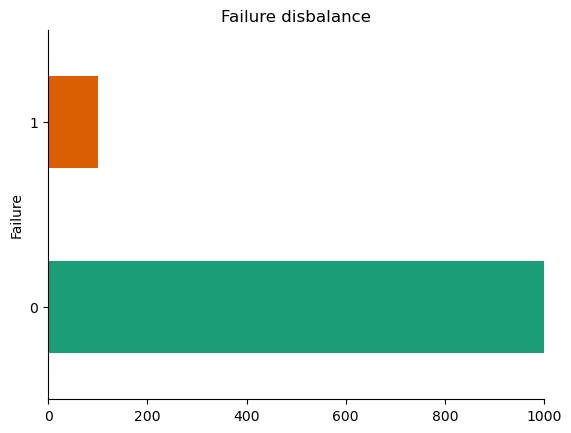

In [29]:
data.groupby('Failure').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Failure disbalance')
plt.xlim(0,1000 )
plt.savefig('Failure disb.jpg', dpi=500)


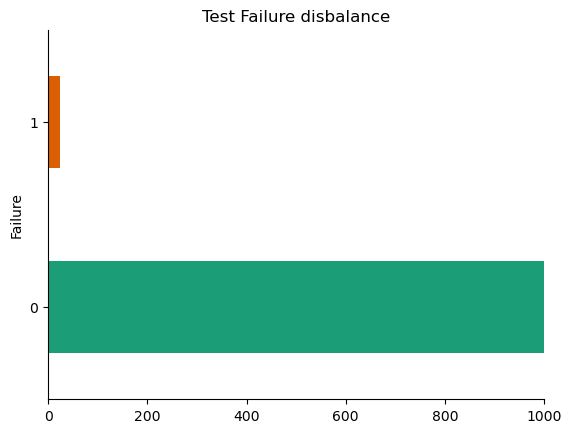

In [30]:
pred_counts = pd.Series(y_test).value_counts()

# Строим график
pred_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Test Failure disbalance')
plt.xlim(0, 1000) # Устанавливаем максимальное значение по оси x равным максимальному количеству записей
plt.savefig('test disb.jpg', dpi=500)
plt.show()

In [31]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=0)

In [32]:
pred=clf.predict(X_test)

In [33]:
pred_processed = np.where(pred==1, 0, 1)

In [34]:
metrics(y_test,pred_processed)

accuracy: 0.6959748144816731
f1: 0.007342143906020559
roc auc: 0.45792711691170696 


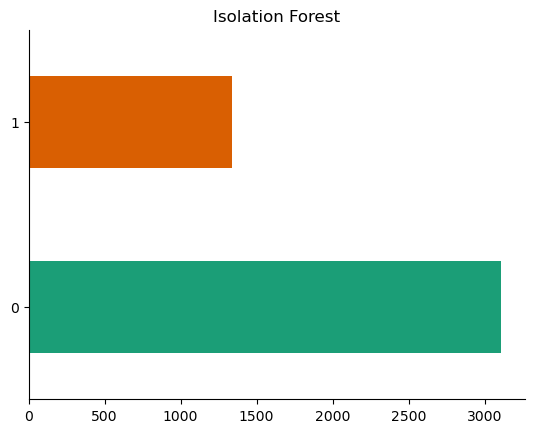

In [50]:
pred_counts = pd.Series(pred_processed).value_counts()

# Строим график
pred_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Isolation Forest') # Устанавливаем максимальное значение по оси x равным максимальному количеству записей
plt.savefig('iso disb.jpg', dpi=500)
plt.show()

In [36]:
from xgboost import XGBClassifier

In [37]:
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Настройка гиперпараметров модели
model.set_params(
    max_depth=3,  # Глубина деревьев
    learning_rate=0.1,  # Скорость обучения
    n_estimators=100,  # Количество итераций (деревьев) в бустинге
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]) , # Установка веса классов
    cuda=True,
    gpu=True
)
# Обучение модели
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, cuda=True, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu=True,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [38]:
xgb_pred=model.predict(X_test)

In [39]:
metrics(y_test, xgb_pred)

accuracy: 0.8556330110186643
f1: 0.024316109422492398
roc auc: 0.603049571507194 


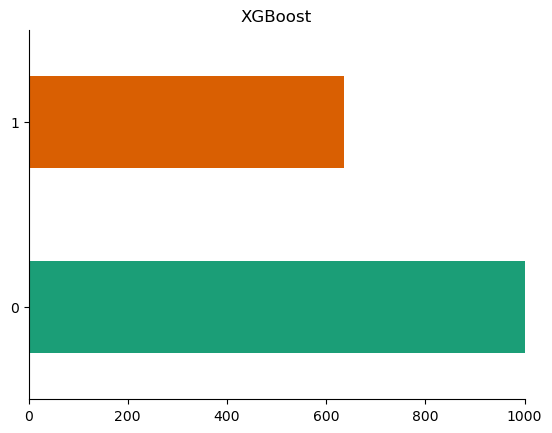

In [40]:
pred_counts = pd.Series(xgb_pred).value_counts()

# Строим график
pred_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('XGBoost')
plt.xlim(0, 1000)
plt.savefig('xgb disb.jpg', dpi=500)
plt.show()

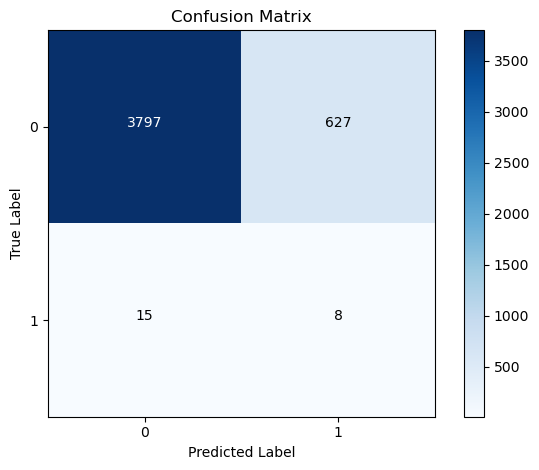

In [41]:
from sklearn.metrics import confusion_matrix
import itertools
# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, model.predict(X_test))

# Построение матрицы ошибок
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Добавление значений в ячейки матрицы ошибок
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('confusion Matrix.png', dpi=1000)
plt.show()

Попробуем нашу модель на абсолютно новых данных

In [42]:
test_df=pd.read_csv('test_mutual_info.csv')

In [43]:
features=test_df.drop(['Failure'],axis=1)
target=test_df['Failure']

In [44]:
features_long = pd.DataFrame({0: features.values.flatten(),
                          1: np.arange(features.shape[0]).repeat(features.shape[1])})
print(features_long.shape)
features_long.head()

(18056, 2)


,0,1
0,10.660000,0
1,39.870406,0
2,51.601842,0
3,10.742682,0
4,34.221452,0


In [45]:
features_tsfresh = extract_features(features_long, column_id=1, impute_function=impute, default_fc_parameters=settings_time)
print(features_tsfresh.shape)

Feature Extraction:   0%|          | 0/30 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


(2257, 10)


In [46]:
features_tsfresh

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
0,219.708105,33.424606,27.463513,8.0,16.677207,278.129240,32.130574,51.601842,51.601842,0.723964
1,220.218105,33.424606,27.527263,8.0,16.613706,276.015240,32.152223,51.601842,51.601842,0.723964
2,219.578105,33.424606,27.447263,8.0,16.693628,278.677202,32.125215,51.601842,51.601842,0.723964
3,220.328105,33.424606,27.541013,8.0,16.600203,275.566739,32.157023,51.601842,51.601842,0.723964
4,220.178105,33.424606,27.522263,8.0,16.618634,276.178988,32.150489,51.601842,51.601842,0.723964
...,...,...,...,...,...,...,...,...,...,...
2252,185.098263,17.857700,23.137283,8.0,17.864282,319.132556,29.231258,57.093347,57.093347,0.000000
2253,183.368263,17.857700,22.921033,8.0,18.026770,324.964455,29.160559,57.093347,57.093347,0.000000
2254,185.998263,17.857700,23.249783,8.0,17.786442,316.357511,29.273024,57.093347,57.093347,0.000000
2255,185.868263,17.857700,23.233533,8.0,17.797399,316.747403,29.266781,57.093347,57.093347,0.000000


In [47]:
xgb_test=model.predict(features_tsfresh)

In [48]:
metrics(target, xgb_test)

accuracy: 0.8595480726628267
f1: 0.006269592476489028
roc auc: 0.4935804802134282 


А что если Catboost решит проблему